# Práctico 6 - Procesamiento Digital de Imágenes

In [1]:
import imageio
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import canny

%matplotlib inline

In [2]:
MAT_RGB2YIQ = np.array([[0.299, 0.587, 0.114],
                        [0.596,-0.275,-0.321],
                        [0.211,-0.523, 0.311]])

def apply_matrix(img, M):
    return np.matmul(img.reshape((-1,3)), M.T).reshape(img.shape)

def rgb2yiq(img):
    return apply_matrix(img, MAT_RGB2YIQ)

def yiq2rgb(img):
    return apply_matrix(img, np.linalg.inv(MAT_RGB2YIQ))

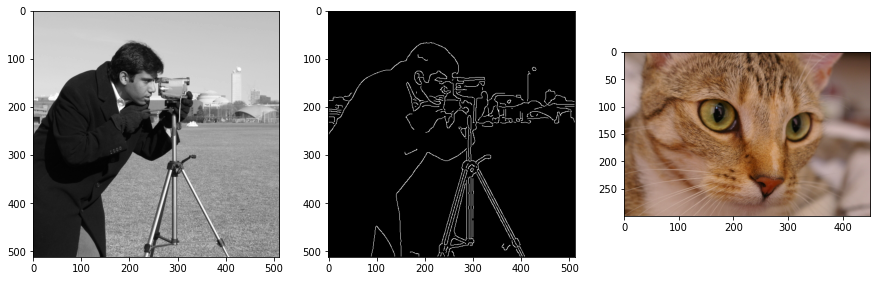

In [3]:
img_gray = imageio.imread('imageio:camera.png')/255
img_rgb = imageio.imread('imageio:chelsea.png')/255
#img_rgb = imageio.imread('letras.png')/255
#img_bin = canny(rgb2yiq(img_rgb)[:,:,0], sigma=2)
img_bin = canny(img_gray, sigma=2)

fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(img_gray, 'gray')
axes[1].imshow(img_bin, 'gray')
axes[2].imshow(img_rgb)

# Operaciones morfológicas

Implementar funciones que devuelvan los siguientes structuring elements. Son similares a un kernel convolucional pero el tipo de dato es booleano (True o False). Incluso pueden construirse aplicando un threshold a un kernel. Ej: se_box = kernel_box > 0

1. Box
2. Circle

Utilizando las funciones de ejemplo implementar las siguientes operaciones morfológicas, tanto para escala de grises como para RGB. Para RGB realizar la operación en base a los valores del canal Y:

Operaciones básicas (nivel 1):

1. Dilatación
2. Erosión
3. Filtro de mediana

Operaciones de suma/resta entre erosión y dilatación:

4. Borde externo
5. Borde interno
6. Gradiente

Operaciones concatenando dilatación y erosión (nivel 2):

7. Apertura (opening)
8. Cierre (closing)
9. Top-hat
10. Bottom-hat

Operaciones concatenando cierre y apertura (nivel 3):

11. OC
12. CO

Funciones útiles a partir de operaciones morfológicas:

13. Suavizado. Puede calcularse como el promedio entre operaciones del mismo nivel. Ej: (dilatación + erosión)/2  o  (apertura + cierre)/2. Los parámetros de entrada deben ser la imagen, el structuring element y el nivel deseado.
14. Realce de contraste (agregar una "porción" de pasaaltos, donde el pasaaltos puede construirse a partir del smoothing). Los parámetros de entrada deben ser los del smoothing utilizado y el factor que mutiplica al pasaaltos.

NOTA: Puede ser conveniente clampear el realce de contraste a [0,1], ya que al agregar pasaaltos la imagen puede salirse del rango. En este caso, matplotlib escala la imagen automáticamente y puede parecer que la luminosidad cambió. 

Aplicaciones útiles:

1. Extracción de texto
2. Eliminación de texto
3. Segmentación del iris del ojo

# Elemento estructurante

In [4]:
# box
def seCuad(tam):
    kernel = np.ones((tam, tam))
    return kernel > 0

# circle
def seCirc(tam):
    tam = np.floor(tam / 2)
    X,Y = np.mgrid[-tam:tam+1:1, -tam:tam+1:1]
    RR = X*X + Y*Y
    kernel = np.where(RR <= tam*tam, 1,0)
    return kernel > 0

print(seCuad(9))
print()
print(seCirc(9))

[[ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]]

[[False False False False  True False False False False]
 [False False  True  True  True  True  True False False]
 [False  True  True  True  True  True  True  True False]
 [False  True  True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True  True  True]
 [False  True  True  True  True  True  True  True False]
 [False  True  True  True  True  True  True  True False]
 [False False  True  True  True  True  True False False]
 [False False False False  Tr

In [5]:
def _morph_op(img, se, fcn):
    '''Implements a general morphologic operation.'''
    se_flip = np.flip(se, axis=[0,1])
    rk, ck = se_flip.shape
    img_pad = np.pad(img, ((rk//2, rk//2), (ck//2, ck//2)), 'edge')
    img_out = np.zeros(img.shape)
    for r,c in np.ndindex(img.shape):
        img_out[r,c] = fcn(img_pad[r:r+rk,c:c+ck][se_flip])
    return img_out

def _morph_multiband(img, se, argfcn):# para MultiBanda
    '''Implements a general morphologic operation on a mutichannel image based on the first channel.'''
    se_flip = np.flip(se, axis=[0,1])
    rk, ck = se_flip.shape
    img_pad = np.pad(img, ((rk//2, rk//2), (ck//2, ck//2), (0,0)), 'edge')
    img_out = np.zeros(img.shape)
    rse, cse = np.where(se_flip)
    for r,c in np.ndindex(img.shape[:2]):
        loc = argfcn(img_pad[r:r+rk,c:c+ck,0][se_flip])
        img_out[r,c] = img_pad[r+rse[loc],c+cse[loc]]
    return img_out

def _morph_color(img, se, argfcn):# para RGB
    '''Applies a morphological operation to a color image based on the 
    Y-channel.
    '''
    img2 = (rgb2yiq(img)[:, :, 0])[:, :, np.newaxis]
    img2 = np.concatenate((img2, img),axis=2)
    result = _morph_multiband(img2, se, argfcn)[:, :, 1:]
    return result

def im_dilate(img, se):# funcion de ejemplo
    '''Morphological dilation for binary, grayscale or RGB images.'''
    if img.ndim == 2:
        return _morph_op(img, se, np.max)
    else:
        return _morph_color(img, se, np.argmax)

In [6]:
se = np.ones((7,7), dtype=bool)

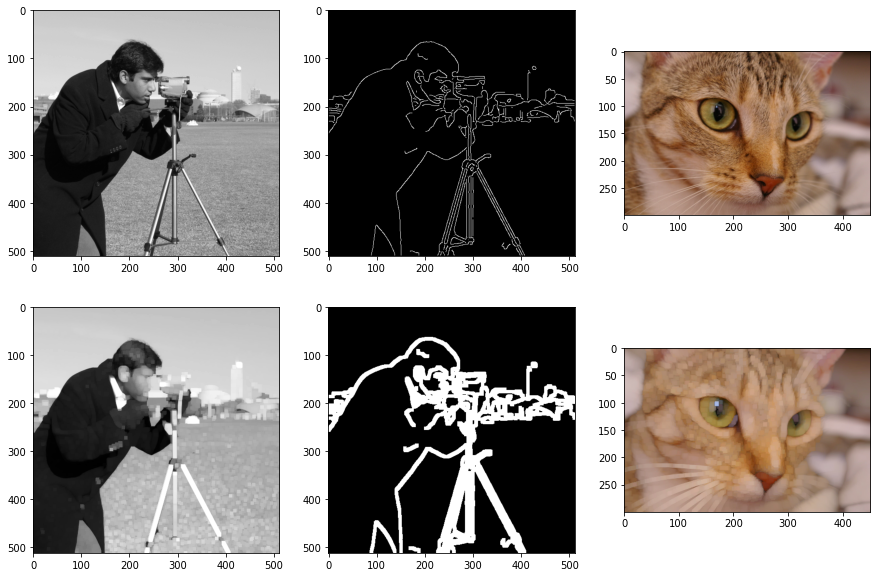

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(im_dilate(img_gray, se), 'gray')
axes[1,1].imshow(im_dilate(img_bin, se), 'gray')
axes[1,2].imshow(im_dilate(img_rgb, se))

# Operaciones básicas (nivel 1):

## Dilatación

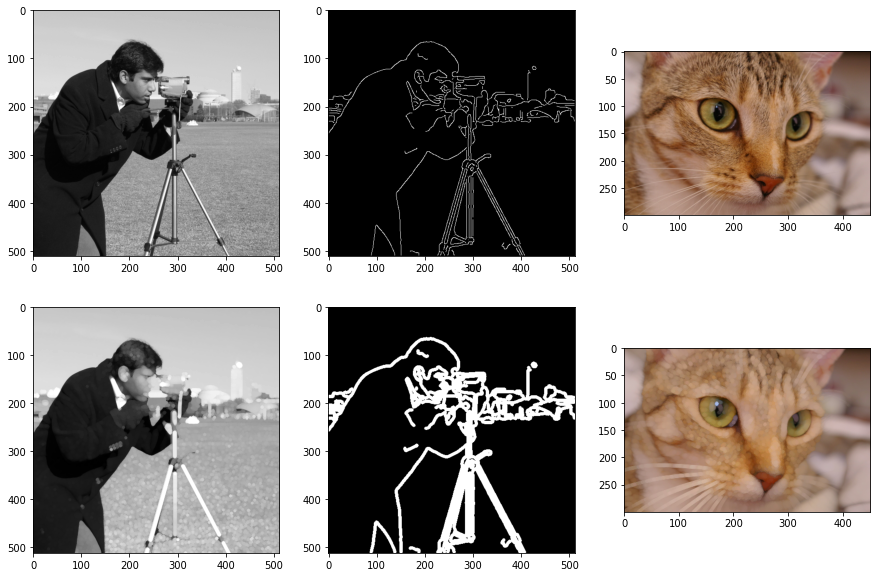

In [8]:
def dilatacion(img, se):
    if img.ndim == 2:
        return _morph_op(img, se, np.max)
    else:
        return _morph_color(img, se, np.argmax)

se = seCirc(7)
    
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(dilatacion(img_gray, se), 'gray')
axes[1,1].imshow(dilatacion(img_bin, se), 'gray')
axes[1,2].imshow(dilatacion(img_rgb , se))

## Erosión

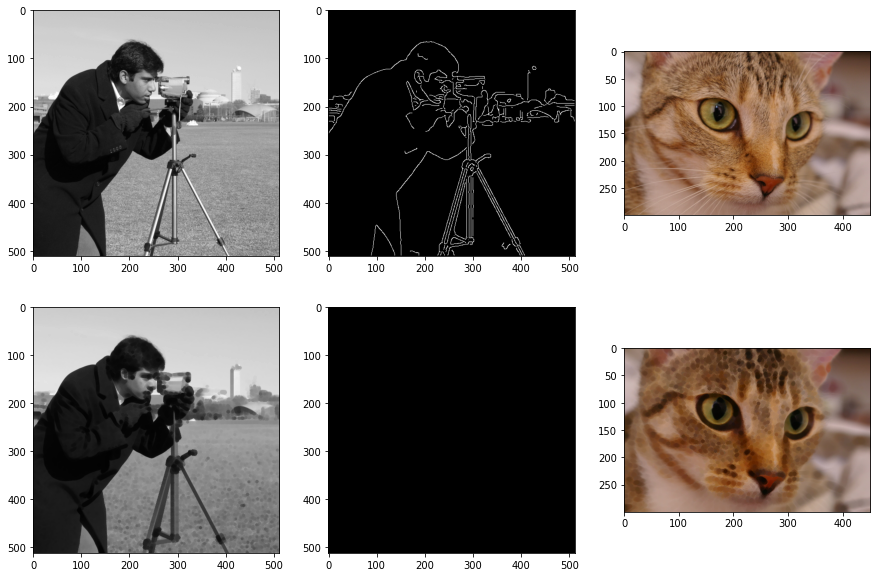

In [9]:
def erosion(img, se):
    if img.ndim == 2:
        return _morph_op(img, se, np.min)
    else:
        return _morph_color(img, se, np.argmin)

se = seCirc(7)
    
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(erosion(img_gray, se), 'gray')
axes[1,1].imshow(erosion(img_bin, se), 'gray')
axes[1,2].imshow(erosion(img_rgb, se))

## Filtro de mediana

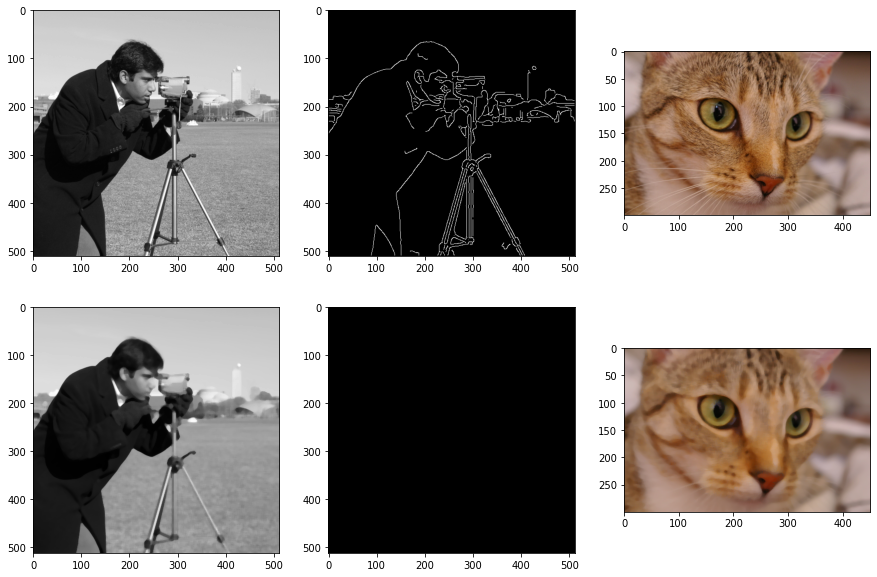

In [10]:
def median_morph_multiband(img, se):# para MultiBanda
    '''Implements a general morphologic operation on a mutichannel image based on the first channel.'''
    se_flip = np.flip(se, axis=[0,1])
    rk, ck = se_flip.shape
    img_pad = np.pad(img, ((rk//2, rk//2), (ck//2, ck//2), (0,0)), 'edge')
    img_out = np.zeros(img.shape)
    rse, cse = np.where(se_flip)
    for r,c in np.ndindex(img.shape[:2]):
        x = img_pad[r:r+rk,c:c+ck,0][se_flip]
        loc = np.argpartition(x, len(x) // 2)[len(x) // 2]
        # loc = argfcn(img_pad[r:r+rk,c:c+ck,0][se_flip])
        img_out[r,c] = img_pad[r+rse[loc],c+cse[loc]]
    return img_out

def median_morph_color(img, se):# para RGB
    '''Applies a morphological operation to a color image based on the 
    Y-channel.
    '''
    img2 = (rgb2yiq(img)[:, :, 0])[:, :, np.newaxis]
    img2 = np.concatenate((img2, img),axis=2)
    result = median_morph_multiband(img2, se)[:, :, 1:]
    return result

def fMediana(img, se):
    if img.ndim == 2:
        return _morph_op(img, se, np.median)
    else:
        return median_morph_color(img, se)

se = seCuad(7)
    
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(fMediana(img_gray, se), 'gray')
axes[1,1].imshow(fMediana(img_bin, se), 'gray')
axes[1,2].imshow(fMediana(img_rgb, se))

# Operaciones de suma/resta entre erosión y dilatación:

## Borde exterior (dilatación menos original)

Minimo y maximo de la imagen original
0.0
0.9058823529411765
Minimo y maximo de la imagen en escalas de grises
0.0
0.8941176470588235
Minimo y maximo de la imagen binaria
0.0
1.0
Minimo y maximo de la imagen RGB
-0.050980392156862786
0.8235294117647058


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


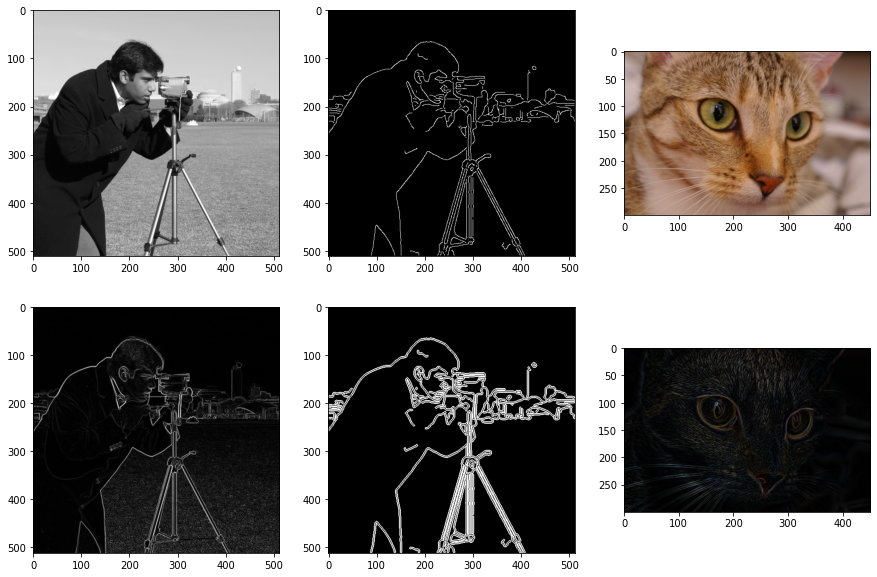

In [11]:
def extBorde(img, se):
    
    return dilatacion(img, se) - img

se = seCirc(5)
fig, axes = plt.subplots(2, 3, figsize=(15,10))

axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(extBorde(img_gray, se), 'gray')
axes[1,1].imshow(extBorde(img_bin, se), 'gray')
axes[1,2].imshow(extBorde(img_rgb, se))

## Borde interior (original menos erosión)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


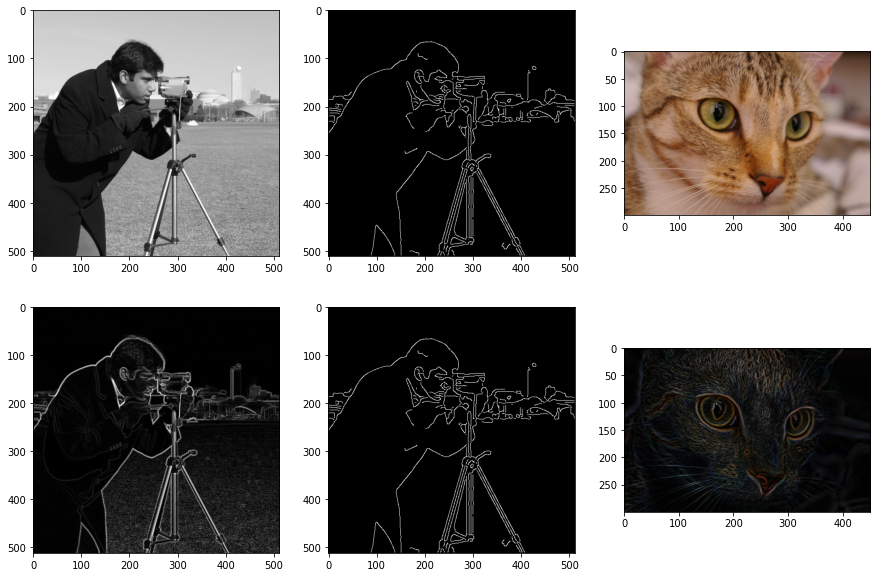

In [12]:
def intBorde(img, se):
    return img - erosion(img, se)

se = seCirc(7)
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(intBorde(img_gray, se), 'gray')
axes[1,1].imshow(intBorde(img_bin, se), 'gray')
axes[1,2].imshow(intBorde(img_rgb, se))

## Gradiente (dilatación menos erosión)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


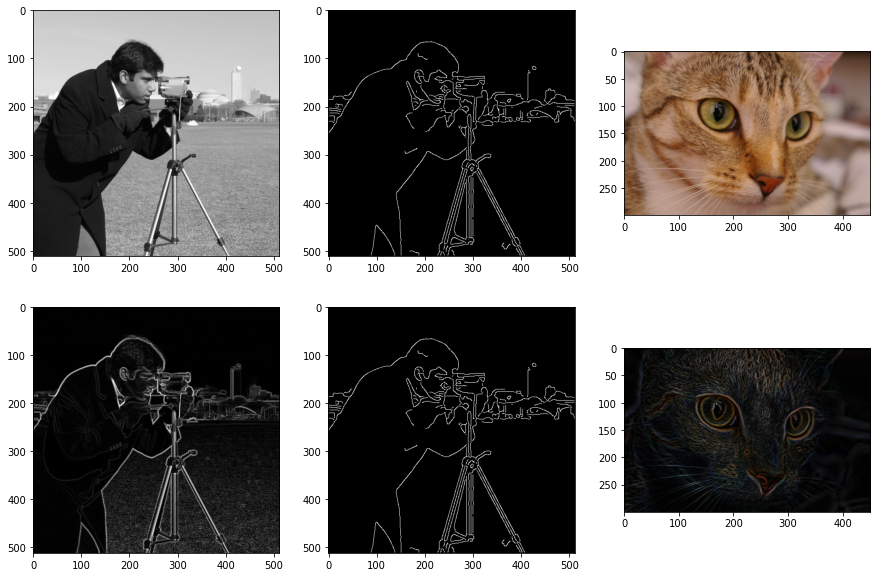

In [13]:
def grad(img, se):
    return dilatacion(img, se) - erosion(img, se)

se = seCirc(7)
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(intBorde(img_gray, se), 'gray')
axes[1,1].imshow(intBorde(img_bin, se), 'gray')
axes[1,2].imshow(intBorde(img_rgb, se))

# Operaciones concatenando dilatación y erosión (nivel 2):

## Apertura (opening)

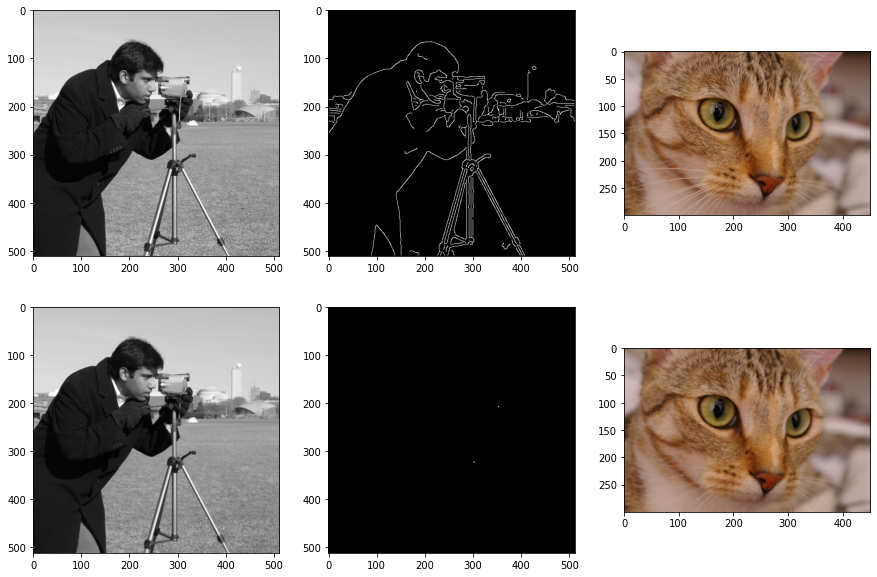

In [14]:
# Apertura (erosión seguida por dilatación)
se = seCirc(3)

def apertura(img, se):
    return dilatacion( erosion(img, se), se )

    
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(apertura(img_gray, se), 'gray')
axes[1,1].imshow(apertura(img_bin, se), 'gray')
axes[1,2].imshow(apertura(img_rgb, se))

## Cierre (closing)

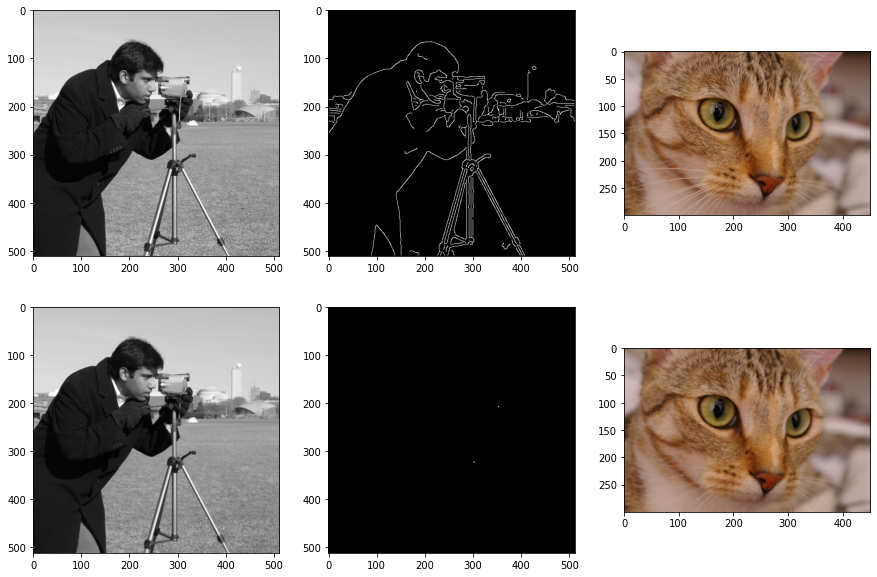

In [15]:
# Cierre (dilatación seguida por erosión)
se = seCirc(3)

def cierre(img, se):
    return erosion( dilatacion(img, se), se )

    
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(apertura(img_gray, se), 'gray')
axes[1,1].imshow(apertura(img_bin, se), 'gray')
axes[1,2].imshow(apertura(img_rgb, se))

## Top-hat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


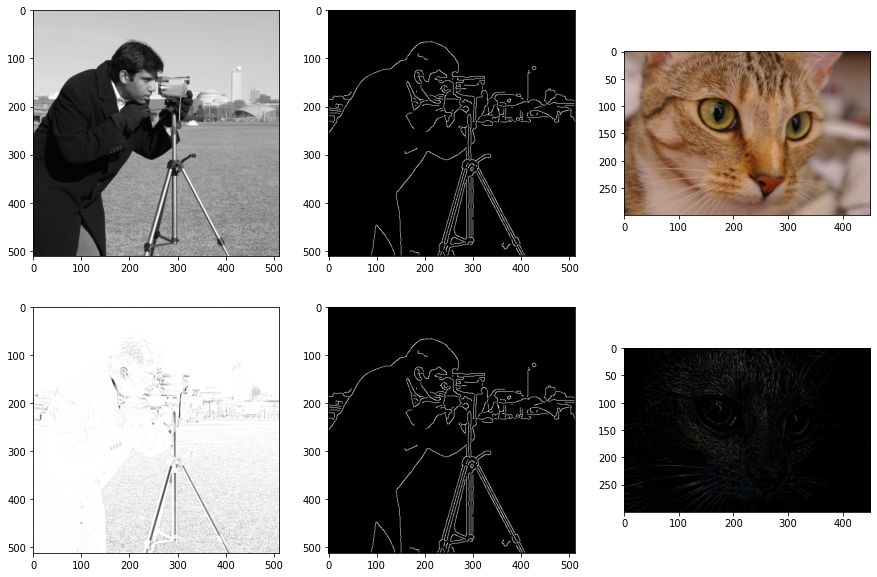

In [16]:
# Top hat (imagen menos apertura)

def topHat( img, se):
    res = apertura(img, se)
    return img - res
    
se = seCirc(7)

fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(-topHat(img_gray, se), 'gray')
axes[1,1].imshow(topHat(img_bin, se), 'gray')
axes[1,2].imshow(topHat(img_rgb, se))

## Bottom-hat (Imagen menos cierre)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


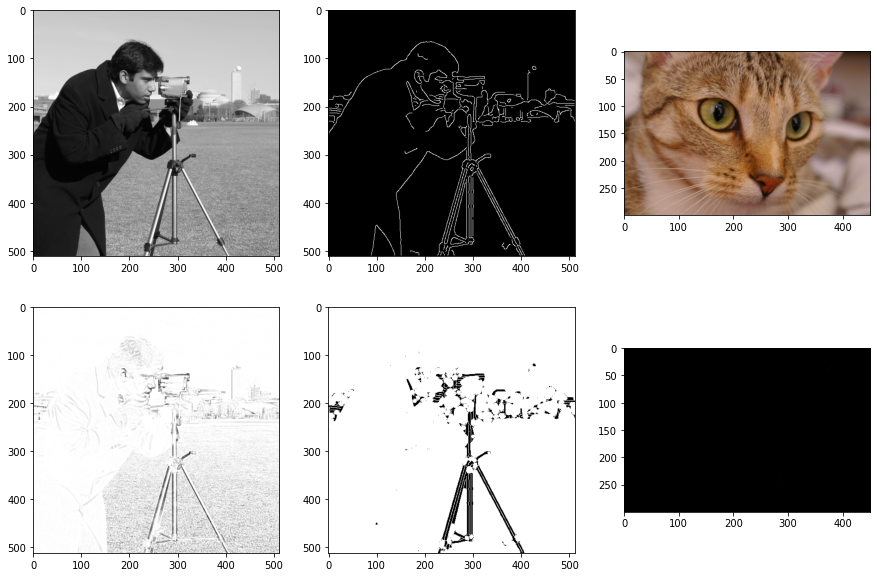

In [17]:
def bottomHat( img, se):
    res = cierre(img, se)
    return img - res
    
se = seCirc(7)

fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(bottomHat(img_gray, se), 'gray')
axes[1,1].imshow(bottomHat(img_bin, se), 'gray')
axes[1,2].imshow(bottomHat(img_rgb, se))

# Operaciones concatenando cierre y apertura (nivel 3):

## OC

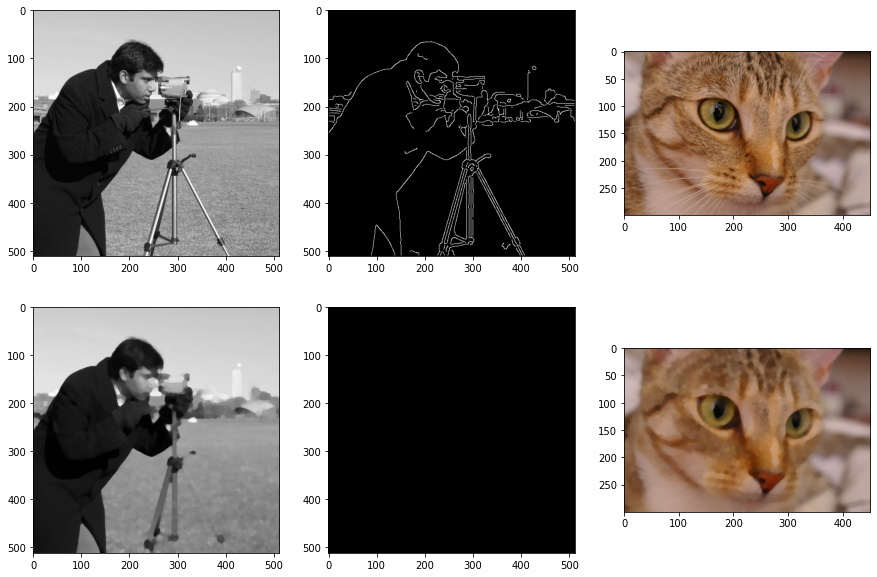

In [18]:
def oc(img, se):
    return cierre(apertura(img, se), se)

se = seCirc(7)

fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(oc(img_gray, se), 'gray')
axes[1,1].imshow(oc(img_bin, se), 'gray')
axes[1,2].imshow(oc(img_rgb, se))

## CO

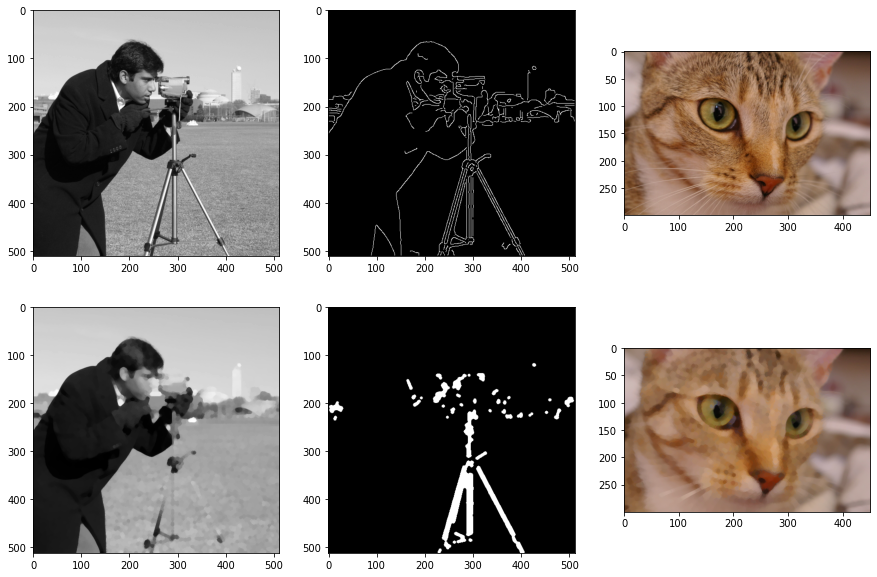

In [19]:
def co(img, se):
    return apertura(cierre(img, se), se)

se = seCirc(7)

fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(co(img_gray, se), 'gray')
axes[1,1].imshow(co(img_bin, se), 'gray')
axes[1,2].imshow(co(img_rgb, se))

# Segmentacion del iris del ojo

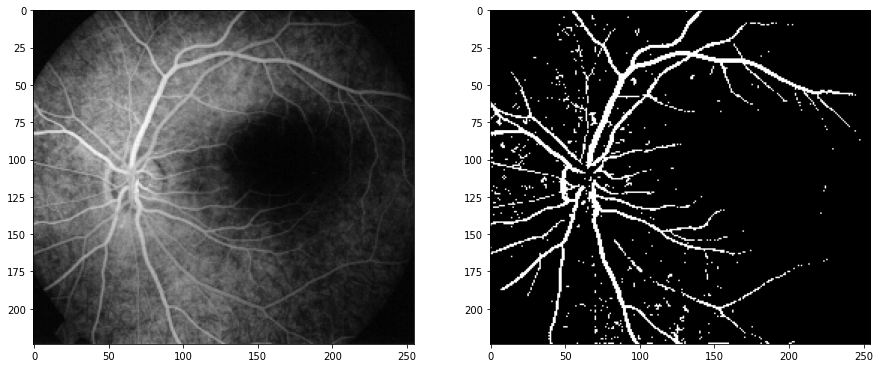

In [20]:
img_iris = imageio.imread('iris.bmp')/255

se = seCirc(9)

fig, axes = plt.subplots(1, 2, figsize=(15,10))
axes[0].imshow(img_iris, 'gray')

topHatIris = topHat(img_iris, se)
topHatIris = np.where( topHatIris  > 0.08, 1, 0 )
axes[1].imshow(topHatIris , 'gray')

# Extracción del texto

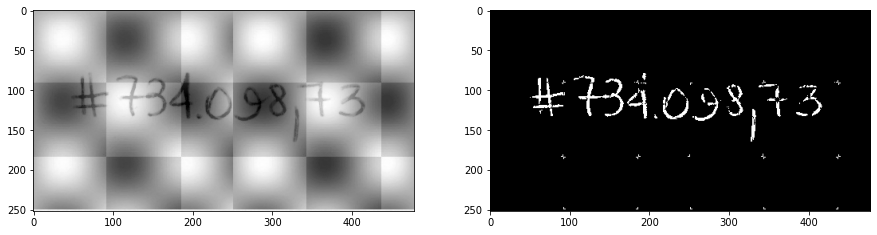

In [21]:
img_text = imageio.imread('text.png')/255

se = seCirc(7)
fig, axes = plt.subplots( 1, 2, figsize=(15,10) )
axes[0].imshow( img_text, 'gray')
btmHat = -bottomHat( img_text, se )

btmHat = np.where( btmHat > 0.08, 1, 0 )

axes[1].imshow( btmHat, 'gray')

# Eliminacion de texto

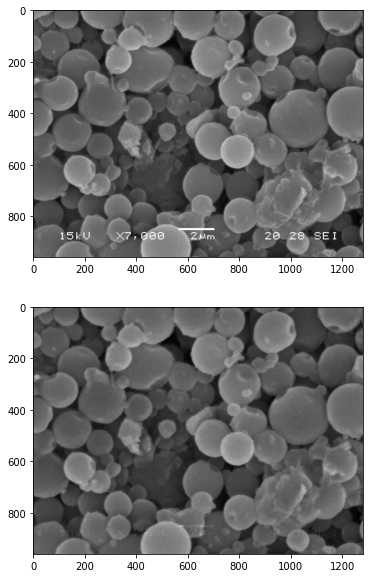

In [22]:
img_text = imageio.imread('particles.png')/255

se1 = seCirc(9)
se2 = seCirc(3)
fig, axes = plt.subplots( 2, 1, figsize=(15,10) )
axes[0].imshow( img_text, 'gray' )

tophat = topHat( img_text, se1 ) - cierre(img_text, se2 )

axes[1].imshow( -tophat, 'gray')